In [3]:
import pandas as pd
import numpy as np
from openpyxl.workbook import Workbook as wb
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils.dataframe import dataframe_to_rows
import scipy
from scipy.stats.stats import pearsonr
import scipy.stats
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [4]:
#downloads MLB team hitting stats in 2019
dfTH = pd.read_csv('TH2019.csv')
#picks out the the values I want (average, on-base pct, slugging, onbase plus slugging, and speed)
dfTHsig = dfTH[['Team','AVG','OBP', 'SLG', 'OPS','Spd']]
df1_index = dfTHsig.set_index('Team')
df1 = df1_index.sort_values(by='Team',ascending=True)
#downloads team pitching 2019
dfTP = pd.read_csv('TP2019.csv')
#picks out the data I want (strikeouts/9, strikeouts to walks, homeruns per 9, strikeout percentage, 
#strikeout to walk percentage, opposing average, Walks hits per inning, batted balls in play, SIERA)
dfTPsig = dfTP[['Team','K/9','HR/9','K%','AVG','WHIP','SIERA']]
df2_index = dfTPsig.set_index('Team')
df2 = df2_index.sort_values(by='Team',ascending=True)
#downloads team wins for 2019
dfTW = pd.read_csv('mlbWins.csv')
#gets values I want such as Wins, Losses, Win Percentage, Home & Away Record, Runs Scored, Runs Allowed, Run Differential
dfTWsig = dfTW[['Team', 'W','L','PCT','HOME','AWAY','RS','RA','DIFF']]
#drops null values
twDf = dfTWsig.dropna()
twDf['Exp Win pct'] = (twDf['RS']**2) / (twDf['RS']**2 + twDf['RA']**2)
df3_index = twDf.set_index('Team')
df3 = df3_index.sort_values(by='Team',ascending=True)
#placing all three dataframes into one dataframe
dfAll = pd.concat([df1,df2,df3], sort=False, axis=1)
dfAll

,AVG,OBP,SLG,OPS,Spd,K/9,HR/9,K%,AVG,WHIP,SIERA,W,L,PCT,HOME,AWAY,RS,RA,DIFF,Exp Win pct
Team,,,,,,,,,,,,,,,,,,,,
Angels,0.247,0.324,0.422,0.746,4.0,8.76,1.67,22.30%,0.252,1.38,4.56,72.0,90.0,0.444,38-43,34-47,769.0,868.0,-99.0,0.439744
Astros,0.274,0.352,0.495,0.848,4.3,10.28,1.42,27.90%,0.219,1.13,3.77,107.0,55.0,0.660,60-21,47-34,920.0,640.0,280.0,0.673885
Athletics,0.249,0.327,0.448,0.776,3.9,7.98,1.23,21.10%,0.239,1.24,4.57,97.0,65.0,0.599,52-29,45-36,845.0,680.0,165.0,0.606945
Blue Jays,0.236,0.305,0.428,0.733,3.8,8.32,1.42,21.10%,0.257,1.43,4.73,67.0,95.0,0.414,35-46,32-49,726.0,828.0,-102.0,0.434645
Braves,0.258,0.336,0.452,0.789,4.6,8.64,1.26,22.30%,0.253,1.36,4.48,97.0,65.0,0.599,50-31,47-34,855.0,743.0,112.0,0.569745
Brewers,0.246,0.329,0.438,0.767,4.4,9.23,1.39,24.00%,0.243,1.33,4.37,89.0,73.0,0.549,49-32,40-41,769.0,766.0,3.0,0.501954
Cardinals,0.245,0.322,0.415,0.737,5.0,8.72,1.19,23.10%,0.235,1.27,4.43,91.0,71.0,0.562,50-31,41-40,764.0,662.0,102.0,0.571165
Cubs,0.252,0.331,0.452,0.783,3.9,9.01,1.22,23.30%,0.247,1.32,4.34,84.0,78.0,0.519,51-30,33-48,814.0,717.0,97.0,0.563104
Diamondbacks,0.252,0.323,0.434,0.757,5.1,8.77,1.35,22.90%,0.248,1.31,4.39,85.0,77.0,0.525,44-37,41-40,813.0,743.0,70.0,0.544896


In [6]:
#creating 'mlbTotals2019.xlsx' excel workbook
dfAll.to_excel('mlbTotals2019.xlsx')

FIND WHY WINS ARE SO HIGH FOR SOME TEAMS AND LOW FOR OTHERS USING REGRESSION

In [5]:
#basic stats for each variable
dfAll.describe()

,AVG,OBP,SLG,OPS,Spd,K/9,HR/9,AVG,WHIP,SIERA,W,L,PCT,RS,RA,DIFF,Exp Win pct
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.252167,0.322433,0.434667,0.757233,4.343333,8.873333,1.406000,0.249167,1.334000,4.412333,80.966667,80.966667,0.499933,782.233333,782.233333,0.000000,0.500555
std,0.010844,0.013851,0.029687,0.042860,0.469544,0.688799,0.182239,0.014162,0.101186,0.301373,15.899433,15.808080,0.097960,90.021332,97.327277,156.501405,0.098224
min,0.236000,0.294000,0.375000,0.673000,3.500000,7.750000,1.100000,0.219000,1.100000,3.770000,47.000000,55.000000,0.292000,582.000000,613.000000,-333.000000,0.288043
25%,0.245250,0.314250,0.416250,0.733750,3.925000,8.432500,1.260000,0.241250,1.292500,4.212500,70.250000,69.000000,0.433500,726.750000,718.750000,-119.000000,0.428663
50%,0.249500,0.323000,0.431000,0.753000,4.350000,8.765000,1.390000,0.248000,1.325000,4.455000,82.500000,79.500000,0.509500,769.000000,769.500000,-3.500000,0.497436
75%,0.260250,0.330500,0.452000,0.782750,4.600000,9.420000,1.517500,0.259250,1.417500,4.630000,93.000000,91.750000,0.574000,842.500000,859.000000,112.000000,0.576336
max,0.274000,0.352000,0.495000,0.848000,5.200000,10.280000,1.900000,0.273000,1.490000,4.890000,107.000000,114.000000,0.660000,943.000000,981.000000,280.000000,0.676275


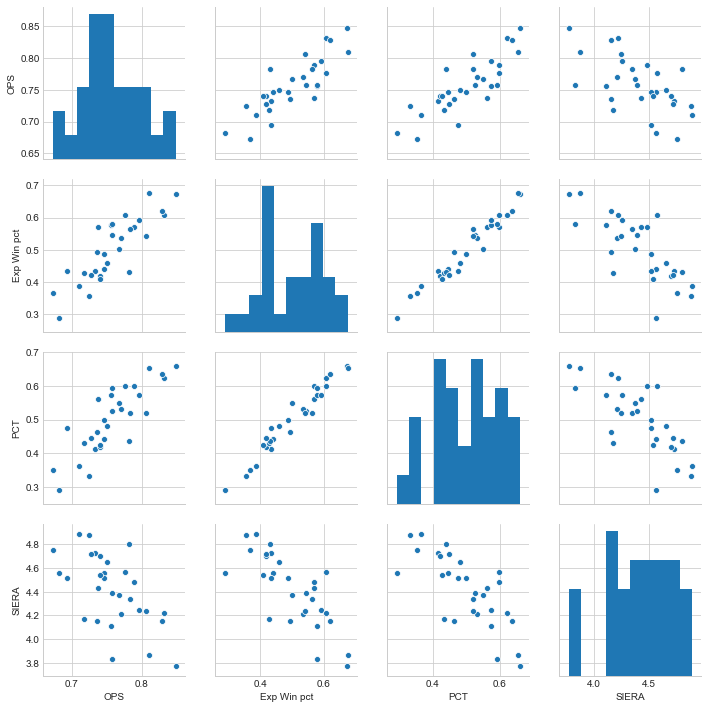

In [7]:
#data visualization
#pearson correlation scatterplots
dfAllxl = pd.read_excel('mlbTotals2019.xlsx')
%matplotlib inline
rcParams['figure.figsize'] = 8,4
plt.style.use('seaborn-whitegrid')
X = dfAllxl[['OPS', 'Exp Win pct','PCT', 'SIERA']]
sb.pairplot(X)

In [8]:
#wins and win pct are the same things or mean the same thing
#correlation using pearsonR (slower than pandas)
wPct = dfAllxl['PCT']
ops = dfAllxl['OPS']
expWin = dfAllxl['Exp Win pct']
siera = dfAllxl['SIERA']
diff = dfAllxl['DIFF']
pearsonr_coefficient, p_value = pearsonr(wPct, ops)
print('PearsonR Correlation Coefficient for wins and ops is %0.3f'% (pearsonr_coefficient))
pearsonr_coefficient, p_value = pearsonr(wPct, siera)
print('PearsonR Correlation Coefficient for wins and siera is %0.3f'% (pearsonr_coefficient))
#for run differential, not sure how significant that is since winning is correlated to a positive differential and vice versa
pearsonr_coefficient, p_value = pearsonr(wPct, diff)
print('PearsonR Correlation Coefficient for wins and diff is %0.3f'% (pearsonr_coefficient))
pearsonr_coefficient, p_value = pearsonr(wPct, expWin)
print('PearsonR Correlation Coefficient for wins and baseball pythag formula is %0.3f'% (pearsonr_coefficient))

PearsonR Correlation Coefficient for wins and ops is 0.828
PearsonR Correlation Coefficient for wins and siera is -0.745
PearsonR Correlation Coefficient for wins and diff is 0.976
PearsonR Correlation Coefficient for wins and baseball pythag formula is 0.975


In [9]:
#correlation of selected variables of dataframe using pandas
dfAllxl = pd.read_excel('mlbTotals2019.xlsx')
Y = dfAllxl[['PCT','OPS', 'Exp Win pct', 'SIERA','Spd', 'HR/9', 'OBP','K/9']]
corr = Y.corr()
corr

,PCT,OPS,Exp Win pct,SIERA,Spd,HR/9,OBP,K/9
PCT,1.000000,0.827814,0.975298,-0.744593,-0.037719,-0.637338,0.846860,0.590108
OPS,0.827814,1.000000,0.840327,-0.592770,-0.018682,-0.321931,0.960693,0.516826
Exp Win pct,0.975298,0.840327,1.000000,-0.760592,-0.027283,-0.666819,0.857950,0.607426
SIERA,-0.744593,-0.592770,-0.760592,1.000000,0.127194,0.622377,-0.613128,-0.904629
Spd,-0.037719,-0.018682,-0.027283,0.127194,1.000000,0.102438,0.088741,-0.121581
HR/9,-0.637338,-0.321931,-0.666819,0.622377,0.102438,1.000000,-0.377297,-0.504141
OBP,0.846860,0.960693,0.857950,-0.613128,0.088741,-0.377297,1.000000,0.569188
K/9,0.590108,0.516826,0.607426,-0.904629,-0.121581,-0.504141,0.569188,1.000000


In [10]:
#correlation of the whole dataframe using pandas (a lot quicker)
Z = dfAllxl
Z.corr()

,AVG,OBP,SLG,OPS,Spd,K/9,HR/9,AVG.1,WHIP,SIERA,W,L,PCT,RS,RA,DIFF,Exp Win pct
AVG,1.000000,0.804886,0.772036,0.797255,0.006659,0.471646,-0.174840,-0.164999,-0.200185,-0.418275,0.572435,-0.575073,0.573177,0.772809,-0.199502,0.568597,0.566312
OBP,0.804886,1.000000,0.915543,0.960693,0.088741,0.569188,-0.377297,-0.468178,-0.500501,-0.613128,0.847350,-0.846441,0.846860,0.937283,-0.505356,0.853413,0.857950
SLG,0.772036,0.915543,1.000000,0.991152,-0.068935,0.478853,-0.284585,-0.348853,-0.428059,-0.565737,0.793792,-0.793432,0.793369,0.956327,-0.413484,0.807233,0.806870
OPS,0.797255,0.960693,0.991152,1.000000,-0.018682,0.516826,-0.321931,-0.395806,-0.462020,-0.592770,0.828259,-0.827729,0.827814,0.968222,-0.453544,0.838988,0.840327
Spd,0.006659,0.088741,-0.068935,-0.018682,1.000000,-0.121581,0.102438,0.199563,0.197993,0.127194,-0.036752,0.038760,-0.037719,0.060448,0.142080,-0.053589,-0.027283
K/9,0.471646,0.569188,0.478853,0.516826,-0.121581,1.000000,-0.504141,-0.697551,-0.657181,-0.904629,0.589758,-0.590643,0.590108,0.402214,-0.623649,0.619201,0.607426
HR/9,-0.174840,-0.377297,-0.284585,-0.321931,0.102438,-0.504141,1.000000,0.650551,0.670916,0.622377,-0.636269,0.636618,-0.637338,-0.287294,0.818166,-0.674067,-0.666819
AVG.1,-0.164999,-0.468178,-0.348853,-0.395806,0.199563,-0.697551,0.650551,1.000000,0.954606,0.807926,-0.701376,0.700397,-0.701232,-0.321688,0.906263,-0.748638,-0.744747
WHIP,-0.200185,-0.500501,-0.428059,-0.462020,0.197993,-0.657181,0.670916,0.954606,1.000000,0.862581,-0.766173,0.765815,-0.766008,-0.389532,0.923337,-0.798280,-0.797334
SIERA,-0.418275,-0.613128,-0.565737,-0.592770,0.127194,-0.904629,0.622377,0.807926,0.862581,1.000000,-0.744381,0.745387,-0.744593,-0.479145,0.786641,-0.764817,-0.760592


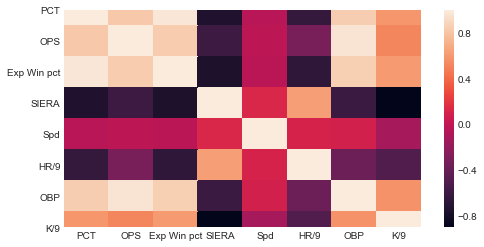

In [11]:
'''heatmap visual using seaborn, darker(black) means stronger 
negative relationship while lighter(cream) means stong positive'''
sb.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

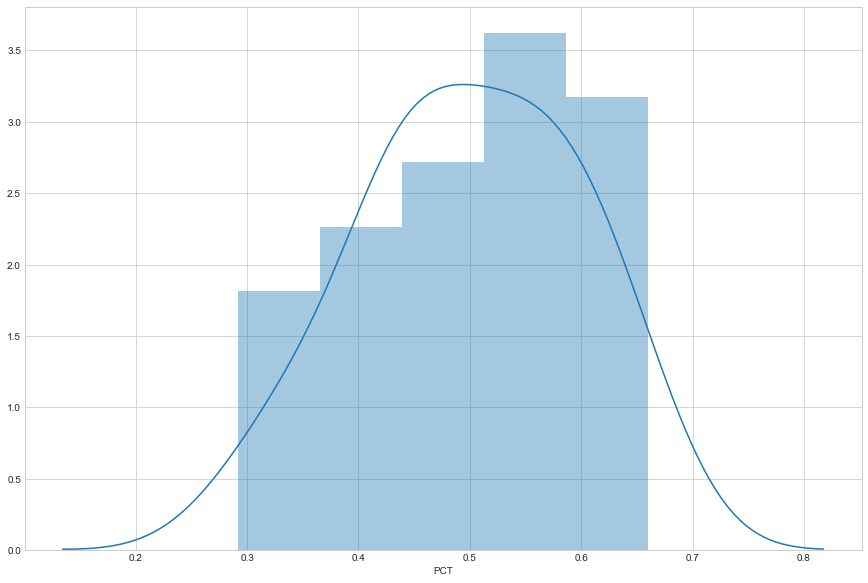

In [12]:
#labeling all of my independent and dependent variables for multiple regression
x = dfAllxl[['AVG','OPS', 'Exp Win pct', 'SIERA','Spd', 'HR/9', 'OBP','K/9','AVG.1', 'DIFF']].values
y = dfAllxl['PCT'].values
#to see the average value of win percentage
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(dfAllxl['PCT'])

In [13]:
#x = dfAllxl[['OBP','Spd']] #on base and speed .977
#x = dfAllxl[['OPS','Spd']] #OPS and speed .981
#x = dfAllxl[['OPS','K/9']] #OPS and strikeouts .978
#x = dfAllxl[['OBP','SIERA']] #OPS and SIERA .992
#x = x = dfAllxl[['AVG','SIERA']] #AVG and SIERA .985
x = dfAllxl[['OPS','SIERA']] #OBP and SIERA .992
regr = linear_model.LinearRegression()
regr.fit(x, y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.030191916313949074
Coefficients: 
 [ 1.36171166 -0.12723246]


In [14]:
'''multiple linear regression model
I removed DIFF and Exp Win pct because they both showed signs of multicollinearity
Exp win pct is a betting formula to predict the true value of a teams winning capability or percentage
Differential is how much runs above or below their competitors on that day
Both are going to show multicollinearity with almost all of these stats
'''
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1802.
Date:                Wed, 15 Apr 2020   Prob (F-statistic):                    2.62e-30
Time:                        02:58:24   Log-Likelihood:                          50.664
No. Observations:                  30   AIC:                                     -97.33
Df Residuals:                      28   BIC:                                     -94.53
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

On-base percentage and SIERA were two best of variables with one of the adjusted highest r-squares  with a low omnibus and high prob(omnibus) and a high kurtosis meaning its a pretty good model. 
AVG and SIERA also had a good model as well as OPS and SIERA

Using a simple model of multiple linear regression, in my opinion, SIERA (Skill-Interactive Earned Run Average) and OPS (On-Base Plus Slugging) produced the best model out of the other 28 residuals with a tied best Adj R-squared of .992 and normal indicators with the likes of Omnibus, P(Omnibus), Durbin-Watson, and JB. OBP and SIERA was also a good model with the same Adj R-squared. 